In [1]:
# Ovaj notebook implementira algoritam za postavljanje svoj. vrijednosti.
# Slučajno generiramo matricu A i vektor b.
# Zadamo neki ciljani spektar lam(1), ..., lam(n).
# Algoritam pronalazi feedback vektor f takav da matrica A + b*f.T ima upravo taj ciljani spektar.

In [1]:
from numpy import *;
from scipy.linalg import *;
from control.matlab import *;
from matplotlib.pyplot import *;

use_numpy_matrix(flag=False, warn=True)

In [2]:
# Generiramo slučajni sustav sa n=4 stanja, m=1 ulazom i p=3 izlaza.
n = 4; m = 1; p = 3;
sys = rss( n, p, m );
A = sys.A;
b = sys.B;

In [3]:
# Ispišimo svoj. vrijednosti od A prije postavljanja.
alpha = eigvals( A );
print( alpha );

[-1.51069669+5.19016779j -1.51069669-5.19016779j -0.61287466+0.j
 -2.1209859 +0.j        ]


In [4]:
# Odaberimo ciljane svojstvene vrijednosti za matricu A + b*f.T.
lam = [-1, -2, -3, -4];

In [5]:
# Odredimo transformaciju koja (A, b) svodi na (H, beta*e_1), tj. m-Hessenberg-trokut formu.
# (u single-input slučaju, trokut = vektor oblika beta*e_1).

# 1. Izračunamo QR-faktorizaciju matrice B.
[Q_B, R_B] = qr( b, mode='full' ); # "puna" faktorizacija: Q_B je n x n, R_B je n x m.
beta = R_B[0, 0];

# 2. Primijenimo sličnost sa Q_B na matricu A.
Atilde = Q_B.T @ A @ Q_B;

# 3. Odredimo ort. trasformaciju koja A prevodi u Hess. formu.
[H, Q_A] = hessenberg( Atilde, calc_q = True );

In [6]:
# Provjera: T = Q_B * Q_A prevodi (A, B) -> (T.T*A*T, T.T*B) koji je Hessenberg-trokut.
T = Q_B @ Q_A;
Atilde = T.T @ A @ T;
Btilde = T.T @ b;

e_1 = eye( n, 1 );
print( norm( Atilde - H, 'fro' ) );
print( norm( Btilde - beta * e_1, 'fro' ) );

print( Atilde )
print( Btilde )

2.4307406214909747e-15
6.063996386506295e-17
[[-3.71245965e+00  2.56643056e+00 -2.97947786e+00 -1.58801538e+00]
 [-5.83427317e+00  2.61130825e+00 -6.37993512e+00  4.37006439e-01]
 [-1.87085879e-16  2.92770903e+00 -2.94581130e+00 -3.32461529e+00]
 [-3.88854511e-16 -2.00068248e-16  1.40327924e+00 -1.70829123e+00]]
[[-4.32515629e-01]
 [ 4.28847655e-17]
 [ 1.71568553e-17]
 [ 3.92905131e-17]]


In [7]:
# Algoritam koji svojstvene vrijednosti nalazi f tako da H + e_1*f' ima spektar lam.
def smjesti( H, e_1, lam ):
    [n, m] = shape( e_1 ); # Algoritam radi samo za m = 1, te e_1=prvi kan.vektor.
    l = zeros( (n, 1) ); l[n-1] = 1.0;
    for i in range( 0, n-1 ):
        l0 = H.T @ l - lam[i] * l;
        l = l0 / norm( l0, 'fro' );
    k = l[0, 0];
    l = H.T @ l - lam[n-1] * l;
    f = -1.0/k * l;
    return f;

f = smjesti( H, b, lam );

[-4.+0.j -1.+0.j -2.+0.j -3.+0.j]


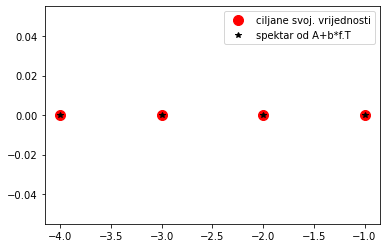

In [9]:
# Provjera: usporedi svojstvene vrijednosti od H + b*f.T sa lam.
%matplotlib inline

ff = T @ f / beta;
lam_tilde = eigvals( A + b @ ff.T );

print( lam_tilde );

figure;
plot( real(lam), imag(lam), 'ro', label='ciljane svoj. vrijednosti', markersize=10 );
plot( real(lam_tilde), imag(lam_tilde), 'k*', label='spektar od A+b*f.T' );
legend();

In [10]:
# U paketu control postoji funkcija place koja radi cijeli ovaj posao za nas.
k = place( A, -b, lam );
print( eigvals( A + b @ k ) )

[-4.+0.j -1.+0.j -2.+0.j -3.+0.j]


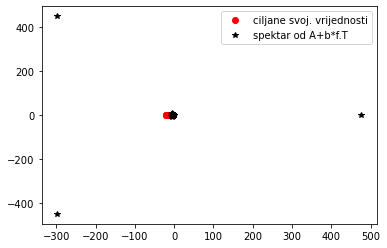

In [11]:
# Procedura dodjeljivanja svojstvenih vrijednosti je numerički nestabilna, 
# tj. sam problem je loše uvjetovan.
# Čim probamo riješiti imalo veći problem, rješenje vjerojatno 
# neće biti zadovoljavajuće točno.
sys = rss( 20, 1, 1 );
A = sys.A;
b = sys.B;
lam = list( range( -22, -2 ) );
k = place( A, -b, lam );
lam_tilde = eigvals( A + b@k );

figure();
plot( real(lam), imag(lam), 'ro', label='ciljane svoj. vrijednosti' );
plot( real(lam_tilde), imag(lam_tilde), 'k*', label='spektar od A+b*f.T' );
legend();